In [1]:
from data_preparation import DataPreparator
from apply_clustering import ClusteringApplier

from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import jensenshannon, correlation, euclidean

In [2]:
import pandas as pd
import numpy as np
import config

import os

In [3]:
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

In [4]:
ClusteringApplier.calculate_observable_patterns()

In [5]:
df: pd.DataFrame = ClusteringApplier._read_observable_data(
    read_only_feature_col=False
)
try:
    clustering_data = df[
        list(config.OBSERVABLE_FEATURE_NAMES.keys())
    ]#.to_numpy()
except:
    print(f"Error. Invalid input.")
    #return None

In [6]:
df.head()

,Individual,num_lhd,num_lying,perc_lhd,perc_lying,oversampled
0,A.nas_01,1.000571,0.250403,0.014091,0.056742,False
1,A.nas_01,1.002405,0.398789,0.017853,0.054594,False
2,A.nas_01,0.999462,0.172592,0.007344,0.030000,False
3,A.nas_01,0.999443,0.426562,0.008964,0.054072,False
4,A.nas_01,0.999517,0.415520,0.010314,0.067722,False


In [7]:
clustering_data

,num_lhd,num_lying,perc_lhd,perc_lying
0,1.000571,0.250403,0.014091,0.056742
1,1.002405,0.398789,0.017853,0.054594
2,0.999462,0.172592,0.007344,0.030000
3,0.999443,0.426562,0.008964,0.054072
4,0.999517,0.415520,0.010314,0.067722
...,...,...,...,...
13723,1.000496,0.374905,0.007175,0.037034
13724,1.001463,0.999097,0.008324,0.106720
13725,0.999115,0.376318,0.004291,0.039456
13726,0.602126,0.999529,0.004062,0.063561


In [8]:
# ClusteringApplier._plot_dendrogram(
#    df=df, x_label=config.OBSERVABLE_NAME, title=""
#)

x_label = config.OBSERVABLE_NAME
title = ''
y_label = "Ward's distance measure"

In [9]:
from visualization.dendogram import fancy_dendrogram, plot_dendrogram

In [10]:
clustering_data = df.loc[:, list(config.OBSERVABLE_FEATURE_NAMES.keys())]

In [11]:
_df = clustering_data.copy(deep=True)

In [12]:
Z = sch.linkage(_df.to_numpy(), method="ward")

Text(0, 0.5, "Ward's distance measure")

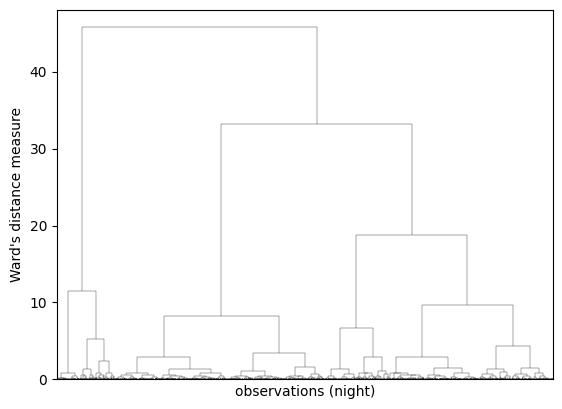

In [13]:
with plt.rc_context({"lines.linewidth": 0.25}):
    sch.dendrogram(
        Z,
        labels=df.index,
        no_labels=True,
        color_threshold=0,
        above_threshold_color="k",
        leaf_rotation=90.0,
    )

plt.title(title)
plt.xlabel(x_label)
plt.ylabel(y_label)

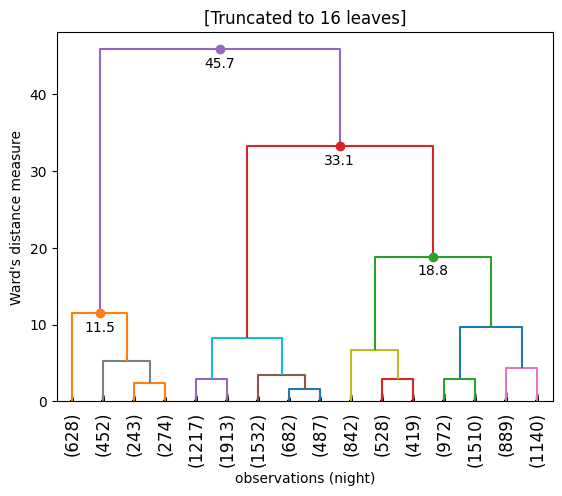

In [14]:
n_cols = len(_df.columns)
p = 16

cm = plt.get_cmap("gist_rainbow")
color_dict = {i: cm(1.0 * i / n_cols) for i in range(n_cols)}
link_color_func = lambda k: f'C{int(k)}'

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=p,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    link_color_func = link_color_func,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)

plt.title(title + f'[Truncated to {p} leaves]')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

In [15]:
# clustering
clusterer = AgglomerativeClustering(
    n_clusters=config.NUMBER_OBSERVABLE_PATTERNS, linkage="ward"
)

In [16]:
clusterer = AgglomerativeClustering(n_clusters=config.NUMBER_OBSERVABLE_PATTERNS, linkage='ward', compute_distances=True)
clusterer.fit_predict(clustering_data)

array([2, 2, 2, ..., 2, 3, 1])

In [17]:
clusterer_labels = clusterer.labels_
df['pattern_type'] = clusterer_labels

In [18]:
df_cluster_median: pd.DataFrame = (
    df.copy()[list(config.OBSERVABLE_FEATURE_NAMES.keys()) + ["pattern_type"]]
    .groupby("pattern_type")
    .median()
)
df_cluster_median

,num_lhd,num_lying,perc_lhd,perc_lying
pattern_type,,,,
0,1.000005,0.625143,0.008053,0.076285
1,0.875462,1.000015,0.006735,0.097272
2,1.000003,0.333075,0.007785,0.048804
3,0.428967,1.000014,0.002308,0.069098
4,0.000028,1.000016,-0.000003,0.037245


In [19]:
# fingerprints
df_observable_data = df[df['oversampled']== False] # from 'is False'

In [20]:
len(df_observable_data.Individual.unique())

132

In [21]:
# Replaces:
# ClusteringApplier._calculate_fingerprints(df_observable_data)

def _calculate_fingerprints(df: pd.DataFrame) -> pd.DataFrame:

    group_names: List[str] = list(set(df[config.GROUP_NAME].to_list()))
    num_clusters: int = max(df["pattern_type"].to_list()) + 1
    group_stat: Dict[str, Dict[int, int]] = {
        grp_name: {j: 0 for j in range(1, num_clusters + 1)}
        for grp_name in group_names
    }

    ret = {j: [] for j in range(1, num_clusters + 1)}
    ret[config.GROUP_NAME] = []

    for row in df.index:
        group_stat[df.loc[row, config.GROUP_NAME]][
            int(df.loc[row, "pattern_type"]) + 1
        ] += 1

    for grp_name in group_stat.keys():
        quantities = group_stat[grp_name]
        N: int = np.sum(list(quantities.values()))
        for j in quantities.keys():
            ret[j].append(quantities[j] / N)
        ret[config.GROUP_NAME].append(grp_name)

    return pd.DataFrame(ret).set_index(config.GROUP_NAME)

# Inkongruent mit Repsonse Types

In [22]:
df_fingerprint = _calculate_fingerprints(df_observable_data)
# Columns enthalten die Pattern types 1-N

In [23]:
df_fingerprint.head()

,1,2,3,4,5
Individual,,,,,
T.eur_02,0.060606,0.000000,0.939394,0.000000,0.0
T.str_01,0.674419,0.290698,0.023256,0.011628,0.0
A.nas_06,0.742857,0.171429,0.085714,0.000000,0.0
O.dam_01,0.352941,0.000000,0.647059,0.000000,0.0
T.eur_09,0.436364,0.018182,0.527273,0.018182,0.0


In [24]:
# Sanity Check:
assert df_fingerprint.sum(axis = 1).apply(lambda x: np.isclose(x, 1)).all(), df_fingerprint.sum(axis = 1)
## -!-> True

In [25]:
# Replaces
# pw_dist, pw_norm_dist = ClusteringApplier.calculate_pairwise_distances(
#    df_fingerprint, list(config.OBSERVABLE_FEATURE_NAMES.keys()), config.DISTANCE_MEASURE_FINGERPRINT
#)

In [26]:
feature_names = list(config.OBSERVABLE_FEATURE_NAMES.keys())
feature_names

['num_lhd', 'num_lying', 'perc_lhd', 'perc_lying']

In [27]:
df_fingerprint

,1,2,3,4,5
Individual,,,,,
T.eur_02,0.060606,0.000000,0.939394,0.000000,0.000000
T.str_01,0.674419,0.290698,0.023256,0.011628,0.000000
A.nas_06,0.742857,0.171429,0.085714,0.000000,0.000000
O.dam_01,0.352941,0.000000,0.647059,0.000000,0.000000
T.eur_09,0.436364,0.018182,0.527273,0.018182,0.000000
...,...,...,...,...,...
C.tau_03,0.214286,0.625000,0.017857,0.142857,0.000000
E.gre_07,0.066667,0.000000,0.000000,0.066667,0.866667
E.qua_24,0.352941,0.147059,0.058824,0.205882,0.235294


In [28]:
def calculate_pairwise_distances(
        df: pd.DataFrame, distance: str
    ) -> Tuple[pd.DataFrame, pd.DataFrame]:

    if distance not in [
        "jensenshannon",
        "euclidean",
        "correlation",
    ]:
        raise Exception(
            "Invalid distance measure used to measure similarity."
        )
    
    distance_matrix: np.array = np.zeros((df.shape[0], df.shape[0]))

    for grp_i in range(df.shape[0]): #zip(group_names, range(len(group_names))):
        for grp_j in range(df.shape[0]): #zip(group_names, range(len(group_names))):        
            fingerprint_1 = df.iloc[grp_i].to_numpy()
            fingerprint_2 = df.iloc[grp_j].to_numpy()
            # config.DISTANCE_MEASURE_FINGERPRINT --> distance
            if distance == "jensenshannon":
                dist: float = 1.0 * jensenshannon(fingerprint_1, fingerprint_2)
            elif distance == "correlation":
                dist = 1.0 * correlation(fingerprint_1, fingerprint_2)
            else:
                dist = 1.0 * euclidean(fingerprint_1, fingerprint_2)
            distance_matrix[grp_i, grp_j] = dist

    normalised_distance_matrix = distance_matrix / np.sum(distance_matrix)

    return pd.DataFrame(
        distance_matrix, columns=df.index, index=df.index
    ), pd.DataFrame(
        normalised_distance_matrix, columns=df.index, index=df.index, 
    )

In [29]:
df_fingerprint.head()

,1,2,3,4,5
Individual,,,,,
T.eur_02,0.060606,0.000000,0.939394,0.000000,0.0
T.str_01,0.674419,0.290698,0.023256,0.011628,0.0
A.nas_06,0.742857,0.171429,0.085714,0.000000,0.0
O.dam_01,0.352941,0.000000,0.647059,0.000000,0.0
T.eur_09,0.436364,0.018182,0.527273,0.018182,0.0


In [30]:
list(config.OBSERVABLE_FEATURE_NAMES.keys())

['num_lhd', 'num_lying', 'perc_lhd', 'perc_lying']

In [31]:
pw_dist, pw_norm_dist = calculate_pairwise_distances(
    df_fingerprint, config.DISTANCE_MEASURE_FINGERPRINT, 
)

In [32]:
# Simple Sanity Check: All self-distances stored in the diagonal must be zero
assert np.isclose(np.diag(pw_norm_dist.to_numpy()), 0.).all(), f'Not all self-distances are zero: {np.diag(pw_norm_dist.to_numpy())}'

In [33]:
pw_norm_dist.head()

Individual,T.eur_02,T.str_01,A.nas_06,O.dam_01,T.eur_09,C.tau_02,R.ful_01,D.pyg_12,C.sim_4,H.equ_02,...,E.zeb_02,C.tau_17,K.ell_01,K.ell_16,E.qua_10,C.tau_03,E.gre_07,E.qua_24,A.nas_02,T.ory_14
Individual,,,,,,,,,,,,,,,,,,,,,
T.eur_02,0.000000,0.000103,0.000093,0.000037,0.000049,0.000020,0.000080,0.000066,0.000028,0.000005,...,0.000062,0.000021,0.000052,0.000013,0.000039,0.000107,0.000113,0.000099,0.000064,0.000110
T.str_01,0.000103,0.000000,0.000021,0.000079,0.000067,0.000089,0.000043,0.000047,0.000097,0.000106,...,0.000052,0.000090,0.000061,0.000101,0.000074,0.000050,0.000106,0.000059,0.000056,0.000044
A.nas_06,0.000093,0.000021,0.000000,0.000066,0.000055,0.000078,0.000041,0.000032,0.000089,0.000096,...,0.000037,0.000078,0.000048,0.000092,0.000061,0.000064,0.000107,0.000061,0.000043,0.000060
O.dam_01,0.000037,0.000079,0.000066,0.000000,0.000019,0.000025,0.000060,0.000038,0.000039,0.000042,...,0.000034,0.000017,0.000024,0.000042,0.000014,0.000096,0.000109,0.000083,0.000033,0.000096
T.eur_09,0.000049,0.000067,0.000055,0.000019,0.000000,0.000033,0.000047,0.000028,0.000043,0.000053,...,0.000023,0.000031,0.000016,0.000050,0.000015,0.000087,0.000107,0.000073,0.000016,0.000085


In [34]:
ClusteringApplier._plot_dendrogram_by_distance_matrix(
    pw_norm_dist.to_numpy(),
    labels=pw_norm_dist.columns,
    x_label=config.GROUP_NAME,
    y_label="Distance of fingerprints",
    title="",
)

In [35]:
# write output
output_path = f"{config.OUTPUT_FOLDER_BASE}observables/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

df_cluster_median.to_excel(
    f"{output_path}{config.DATASET_NAME}-observable-patterns-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index_label="pattern_type",
)
df_observable_data.to_excel(
    f"{output_path}{config.DATASET_NAME}-cluster_assignment-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index=True # ?
)
df_fingerprint.to_excel(
    f"{output_path}{config.DATASET_NAME}-fingerprint-observables-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index=True # ?
)
pw_dist.to_excel(
    f"{output_path}{config.DATASET_NAME}-distance-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx"
)
pw_norm_dist.to_excel(
    f"{output_path}{config.DATASET_NAME}-distance-normalized-matrix-{config.DISTANCE_MEASURE_FINGERPRINT}-{config.NUMBER_OBSERVABLE_PATTERNS}.xlsx",
    index=True
)

In [36]:
from visualize_result import ResultVisualizer

'''ResultVisualizer.plot_simple_radar_chart(
    observable_patterns=[
        df_cluster_median.loc[row, :].to_list()
        for row in sorted(df_cluster_median.index)
    ],
    observable_labels=list(config.OBSERVABLE_FEATURE_NAMES.keys()),
)'''

'ResultVisualizer.plot_simple_radar_chart(\n    observable_patterns=[\n        df_cluster_median.loc[row, :].to_list()\n        for row in sorted(df_cluster_median.index)\n    ],\n    observable_labels=list(config.OBSERVABLE_FEATURE_NAMES.keys()),\n)'

In [37]:
#tst = [[1,0,0,0], [0,1,0,0], [0,0,0,1], [0,0,1,0]]
tst = np.array([
        df_cluster_median.loc[row, :].to_list()
        for row in sorted(df_cluster_median.index)
    ])
observable_labels=list(config.OBSERVABLE_FEATURE_NAMES.keys())
observable_labels

['num_lhd', 'num_lying', 'perc_lhd', 'perc_lying']

In [38]:
# Vorher nochmal jedes Feature 
observable_patterns = tst / tst.sum(axis=0)


In [39]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

max_fingerprints_per_col = 3

num_rows = int(np.ceil(len(observable_patterns)/max_fingerprints_per_col))
num_cols = min(len(observable_patterns), max_fingerprints_per_col)

fig = make_subplots(rows=num_rows, cols=num_cols, specs=[[{'type': 'polar'}]*num_cols]*num_rows, horizontal_spacing=0.2, vertical_spacing=0.0)

for j in range(len(observable_patterns)):
    row = j // max_fingerprints_per_col + 1
    col = j % num_cols + 1
    current_pattern: np.array = np.array(observable_patterns[j]) / np.sum(
        np.array(observable_patterns[j])
    )
    fig.add_scatterpolar(r=current_pattern, theta=observable_labels, fill="toself", row=row, col=col)

fig.update_layout(
    showlegend=False,
    plot_bgcolor="rgba(0, 0, 0, 0)",
    paper_bgcolor="rgba(0, 0, 0, 0)",
    title=config.OBSERVABLE_PATTERN_NAME_PLURAL,
)

fig.update_polars(dict(radialaxis=dict(visible=True, range=[0,1], showticklabels=False)))
 # range = [0, 1] !
fig.update_layout(height=800, width=800)

fig.write_image('tst.png', engine='kaleido')


In [40]:
...

Ellipsis

In [41]:
import warnings

try:
    import kaleido
except:
    warnings.warn('kaleido not found, try pip install --upgrade "kaleido==0.1.*"')

if kaleido.__version__ != '0.1.0.post1':
    warnings.warn(f'kaleido version {kaleido.__version__} may not be able to save the resulting plots, if you encounter problems try using version 0.1.0.post1 instead')


True